## **AAI 521 Group 3 Project: Classification of Cats and Dogs**

In [3]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
import cv2
import pathlib, random, math
#!pip install split-folders
#import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from matplotlib.image import imread

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install kaggle packages
#!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#! mkdir ~/.kaggle # make directory (temp)
#! cp kaggle.json ~/.kaggle/ # json permissions file
#! chmod 600 ~/.kaggle/kaggle.json # read & write json file

In [ ]:
# d/l dog & cat datasets
#! kaggle competitions download -c dogs-vs-cats

In [5]:
# Unzip folders
#! unzip dogs-vs-cats.zip
! unzip train.zip
! unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

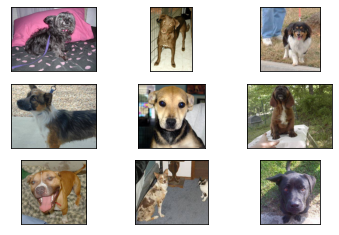

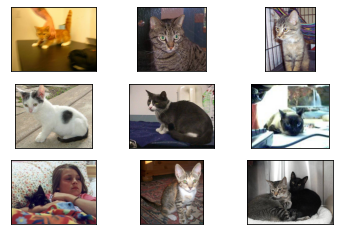

In [6]:
# plot dog & cats photos from train dataset

# define location of training dataset
folder = '/content/train/'
# plot first 9 images of dogs
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.xticks([])
    plt.yticks([])
    file = folder + 'dog.' + str(i) + '.jpg'
    image = imread(file)
    plt.imshow(image)
plt.show()

# plot first 9 images of cats
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.xticks([])
    plt.yticks([])
    file = folder + 'cat.' + str(i) + '.jpg'
    image = imread(file)
    plt.imshow(image)
plt.show()

In [7]:
# training dataset size
# assign size
size = 0
 
# assign folder path
folder_path = '/content/train'
 
# get size
for path, dirs, files in os.walk(folder_path):
    for f in files:
        fp = os.path.join(path, f)
        size += os.path.getsize(fp)
 
# show dataset size
print("Training dataset size: " + str(size) + " Bytes or " + str(size/1000000) + " MB")

Training dataset size: 571915376 Bytes or 571.915376 MB


In [8]:
# create training & testing subdirectories with dogs & cats labels
from os import makedirs

dataset_main = 'dogs_vs_cats_train_test/'
subdirectory = ['train/', 'test/']
for subdir in subdirectory:
    label_directory = ['dogs/', 'cats/']
    for labeldir in label_directory:
      directory = dataset_main + subdir + labeldir
      makedirs(directory, exist_ok=True)

In [9]:
# Splitting images into training & test subdirectories
from os import listdir
from shutil import copyfile
from random import random
from random import seed # for random number generator

seed(1) 
train_dir = 'train/' #contains all images
for file in listdir(train_dir):
    source = train_dir + '/' + file
    destination_dir = 'train/'
    if random() < 0.20:       #20% for validation, 80% for training
       destination_dir = 'test/'
    if file.startswith('cat'):
       destination = dataset_main + destination_dir + 'cats/' + file
       copyfile(source, destination) #copying from source to destination
    elif file.startswith('dog'):
        destination = dataset_main + destination_dir + 'dogs/' + file
        copyfile(source, destination)

In [10]:
# Number of images within train & test

tr_dogs = os.listdir('/content/dogs_vs_cats_train_test/train/dogs/')
tr_dogs_total = len(tr_dogs)

tr_cats = os.listdir('/content/dogs_vs_cats_train_test/train/cats/')
tr_cats_total = len(tr_cats)

tst_dogs = os.listdir('/content/dogs_vs_cats_train_test/test/dogs/')
tst_dogs_total = len(tst_dogs)

tst_cats = os.listdir('/content/dogs_vs_cats_train_test/test/cats/')
tst_cats_total = len(tst_cats)

print('Number of dog images in train:\n', tr_dogs_total)
print('Number of cats images in train:\n', tr_cats_total)
print('Number of dog images in test:\n', tst_dogs_total)
print('Number of cats images in test:\n', tst_cats_total)
print('Total images in train and test:\n', tr_dogs_total + tr_cats_total + tst_dogs_total + tst_cats_total)

Number of dog images in train:
 9908
Number of cats images in train:
 10002
Number of dog images in test:
 2592
Number of cats images in test:
 2498
Total images in train and test:
 25000


In [11]:
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.reshaping.up_sampling2d import UpSampling2D
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [12]:
# Draw learning curve
def learning_curve(hist):
    # Accuracy curve plot
    fig = plt.figure()
    plt.subplot(2,1,1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    # Loss curve plot
    plt.subplot(2,1,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.tight_layout() # create vertical space between plot fig
    fig

In [13]:
# Train/test paths
train_path = '/content/dogs_vs_cats_train_test/train/'
test_path = '/content/dogs_vs_cats_train_test/test'

In [14]:
# Create train/test data generators
data_gen = ImageDataGenerator(featurewise_center=True)

# Imagenet mean values for centering
data_gen.mean = [123.68, 116.779, 103.939] 

# Create train/test iterators
train_it = data_gen.flow_from_directory(train_path, 
                                      class_mode='binary', batch_size=32, target_size=(224, 224))
test_it = data_gen.flow_from_directory(test_path,
                                      class_mode='binary', batch_size=32, target_size=(224, 224))

Found 19910 images belonging to 2 classes.
Found 5090 images belonging to 2 classes.


In [24]:
# Load model
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
 
# Mark loaded layers as not trainable
for layer in model.layers:
	  layer.trainable = False

# Add new classifier layers
flat1 = Flatten()(model.layers[-1].output)

batch_n1 = BatchNormalization()(flat1)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(batch_n1) # He_uniform variance scaling initializer
drop1 = Dropout(0.50)(class1) # dropout regularization
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(drop1)
drop2 = Dropout(0.50)(class2)
batch_n2 = BatchNormalization()(drop2)
output = Dense(1, activation='sigmoid')(batch_n2)
 
# Define new model
model = Model(inputs=model.inputs, outputs=output)
 
# Compile model
opt = SGD(learning_rate=0.001, momentum=0.9) 
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Fit model
hist = model.fit(train_it, validation_data=test_it, epochs=5)

Epoch 1/5
623/623 [==============================] - 146s 233ms/step - loss: 0.2286 - accuracy: 0.9050 - val_loss: 0.1054 - val_accuracy: 0.9595
Epoch 2/5
623/623 [==============================] - 141s 225ms/step - loss: 0.1160 - accuracy: 0.9589 - val_loss: 0.0826 - val_accuracy: 0.9695
Epoch 3/5
623/623 [==============================] - 141s 226ms/step - loss: 0.0898 - accuracy: 0.9669 - val_loss: 0.0754 - val_accuracy: 0.9705
Epoch 4/5
623/623 [==============================] - 141s 226ms/step - loss: 0.0759 - accuracy: 0.9730 - val_loss: 0.0694 - val_accuracy: 0.9731
Epoch 5/5
623/623 [==============================] - 140s 225ms/step - loss: 0.0639 - accuracy: 0.9779 - val_loss: 0.0675 - val_accuracy: 0.9731


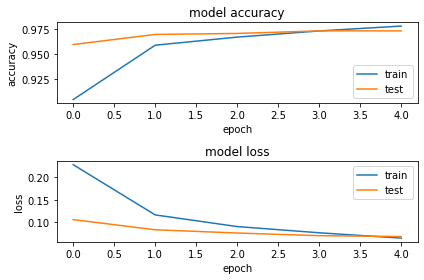

In [26]:
# Plot learning curves
learning_curve(hist)

In [27]:
# Evaluate model 
val = model.evaluate(test_it, verbose=1)
print('The model accuracy is:', '%.2f' % (val[1]*100),'%')

160/160 [==============================] - 28s 177ms/step - loss: 0.0675 - accuracy: 0.9731
The model accuracy is: 97.31 %


In [28]:
# Make predictions
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

def image_load(file):
	  # load image
		image = load_img(file, target_size=(224, 224))
		# array conversion
		image = img_to_array(image)
	  # reshape
		image = image.reshape(1, 224, 224, 3)
	  # pixel data centering
		image = image.astype('float32')
		image = image - [123.68, 116.779, 103.939] # Imagenet mean values for centering
		return image

In [1]:
# Show image predicted & class predicted

file = 'cat_predict.jpg' # dog_predict.jpg / cat_predict.jpg
img = image_load(file)
predication = model.predict(img)
print()

# Assign prediction[0] to "Dog" or "Cat" class
if (predication[0] > 0.5):
    print("For the image below, the model predicts a Dog \n")
elif (predication[0] < 0.5): 
    print("For the image below, the model predicts a Cat \n")

image = imread(file)
plt.imshow(image)
plt.show()

## **Image Segmentation: Eliminating Background**

In [5]:
# Load and copy image
image_read = cv2.imread(file)
#img = cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB)
img = image_read.copy()

# Make zero filled mask with same image shape
mask = np.zeros(img.shape[:2], np.uint8)

# Image shape
print('Image Shape:', img.shape)

Image Shape: (224, 225, 3)


In [ ]:
# Make zero filled background and foreground models
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)

In [ ]:
import math
# Upper left rect corner
x1 = math.floor(0.02*img.shape[1]) 
y1 = math.floor(0.02*img.shape[0])

# Bottom right rect corner
x2 = math.floor(0.98*img.shape[1])
y2 = math.floor(0.98*img.shape[0])

print(y1, x1, x2, y2)

4 4 220 219


In [ ]:
# Make rectangle to isolate object of interest
rect = (y1, x1, x2, y2) # define rectangle

# Apply GrubCut with arguments
cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 7, cv2.GC_INIT_WITH_RECT)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 2, 0],
        [0, 0, 0, ..., 2, 2, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[3.01431262e-01, 1.50357815e-01, 2.73483992e-01, 7.95480226e-02,
         1.95178908e-01, 2.10653880e+02, 2.27332500e+02, 2.34278271e+02,
         1.19227204e+02, 1.54873747e+02, 1.90169088e+02, 1.90746316e+02,
         2.06373915e+02, 2.18107148e+02, 8.90951705e+01, 1.02116951e+02,
         1.73059659e+02, 1.65277499e+02, 1.89421459e+02, 2.09772096e+02,
         8.24317440e+01, 6.50854712e+01, 6.56534812e+01, 6.50854712e+01,
         5.78288413e+01, 5.52852083e+01, 6.56534812e+01, 5.52852083e+01,
         6.02648121e+01, 8.56241214e+02, 5.61572523e+02, 5.52201813e+02,
         5.61572523e+02, 4.22133359e+02, 4.34675656e+02, 5.52201813e+02,
         4.34675656e+02, 5.15930077e+02, 1.04246345e+02, 1.00122401e+02,
         1.11728462e+02, 1.00122401e+02, 1.0

In [ ]:
# Define second mask (keeps foreground object, darkens background)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Apply mask2 to image
img = img*mask2[:,:,np.newaxis]

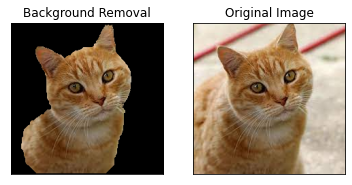

In [ ]:
# Plot images
plt.subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Background Removal')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(cv2.cvtColor(image_read, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.show()